# Testing Notebook

### Import libraries

In [28]:
import sys
import os
import pickle

# Manually specify the path to the 'src' directory
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))

# Add the specified path to the system path
sys.path.append(src_path)

# Third-party libraries
import networkx as nx
from qiskit import transpile
import mapomatic as m
import random

# Local application/library imports
import backend_gen as backendGen
import circuit_gen as circuitGen
import qubit_mapping as qMap

### Parameters Configuration

In [29]:
num_modules        = 4
module_max_qubits  = 4
module_max_gates   = 6
buffer_distance    = 0
reduced_distance   = 3
max_allowed_weight = 3
num_qubits_x       = 5
num_qubits_y       = 5
heuristic          = False
save_backend       = False
seed               = random.randint(1, int(1e4))

In [30]:
print(f'Seed: {seed}')

Seed: 6312


### Random Circuit Generation and Mapping Computation

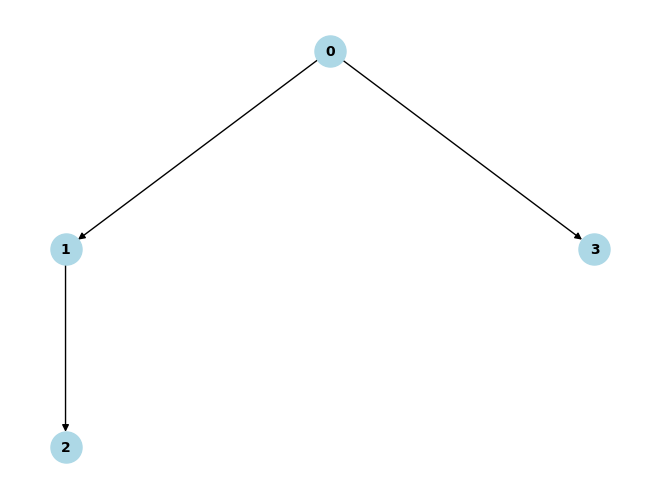

In [31]:
# Generate random circuit
circuit = circuitGen.RandomCircuit(num_modules, module_max_qubits, module_max_gates, seed)
circuit.gen_random_circuit()

# Ploy dependency graph
circuit.draw_dependency_graph()

In [32]:
# Use a saved backend
# with open('backends/backend_10x10_grid.pkl', 'rb') as file:
#     backend = pickle.load(file)

In [33]:
# Generate the Quantum Circuit Mapping
q_map = qMap.QubitMapping(
    circuit, 
    backend=backendGen.generate_regular_backend(num_qubits_x, num_qubits_y),
    buffer_distance=buffer_distance, 
    reduced_distance=reduced_distance, 
    max_allowed_weight=max_allowed_weight,
    heuristic=heuristic
)
q_map.generate_qubit_mapping()
print(f"Qubit modules:  {q_map.modules_qubits}")
print(f"Qubit mapping: {q_map.qubit_mapping}")

Nodes order: f[[0], [1], [3, 2]]
Qubit modules:  {0: [0, 1], 1: [1, 2], 2: [2, 6], 3: [0, 3, 4, 5]}
Qubit mapping: [{0: [7, 6]}, {1: [6, 7]}, {2: [12, 17], 3: [7, 6, 2, 3]}]


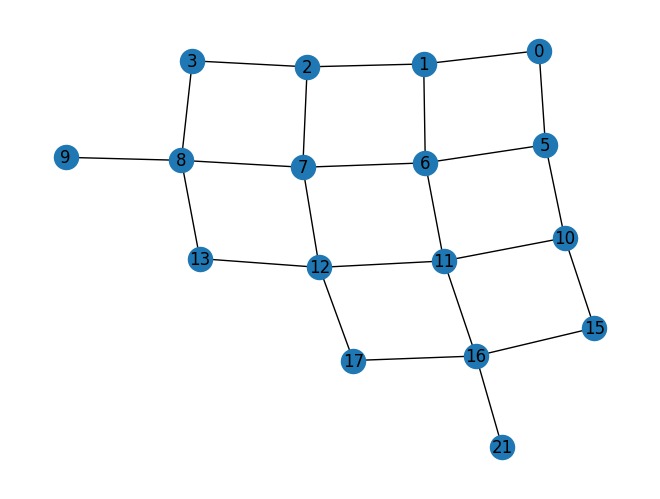

In [34]:
# Draw reduced coupling graph
couplings = q_map.reduced_coupling_maps[0].get_edges()
qc_graph  = nx.from_edgelist(couplings)
pos = nx.kamada_kawai_layout(qc_graph) 
nx.draw(qc_graph, pos, with_labels=True)

In [35]:
# Initialize the timestep variable
timestep = 0

Chosen layouts: {2: [12, 17], 3: [7, 6, 2, 3]}


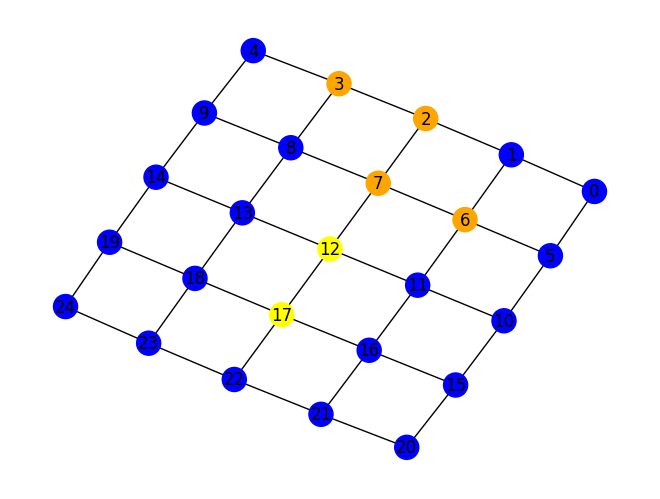

In [41]:
def generate_layouts(module, backend):
    """ Searches for, optimizes and evaluates quantum circuit layouts for a specified backend. """    
    trans_qc = transpile(module, backend, optimization_level=3)
    small_qc = mm.deflate_circuit(trans_qc)
    layouts = mm.matching_layouts(small_qc, backend)
    scores = mm.evaluate_layouts(small_qc, layouts, backend)
    return scores

backend   = q_map.backend
couplings = backend.coupling_map.get_edges()
qc_graph  = nx.from_edgelist(couplings)

# Retrieve the qubits associated with each chosen layout
chosen_layouts = q_map.qubit_mapping[timestep]
print(f"Chosen layouts: {chosen_layouts}")

# Plot the quantum circuit graph with the chosen layout for each mapped module
colors    = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink']
color_map = []

for node in qc_graph:
    in_layout = False
    for (moduleIndex, layout) in chosen_layouts.items():
        if node in layout:
            color_map.append(colors[moduleIndex + 1])
            in_layout = True            

    if not in_layout:
        color_map.append(colors[0])

pos = nx.kamada_kawai_layout(qc_graph) 
nx.draw(qc_graph, pos, node_color=color_map, with_labels=True)

timestep += 1
if timestep == len(q_map.qubit_mapping):
    timestep = 0

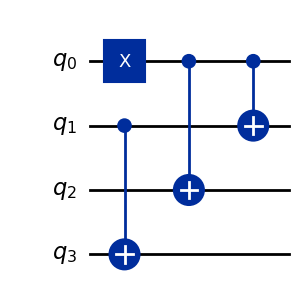

In [37]:
# Plot module of the circuit
circuit.modules[3].draw('mpl')

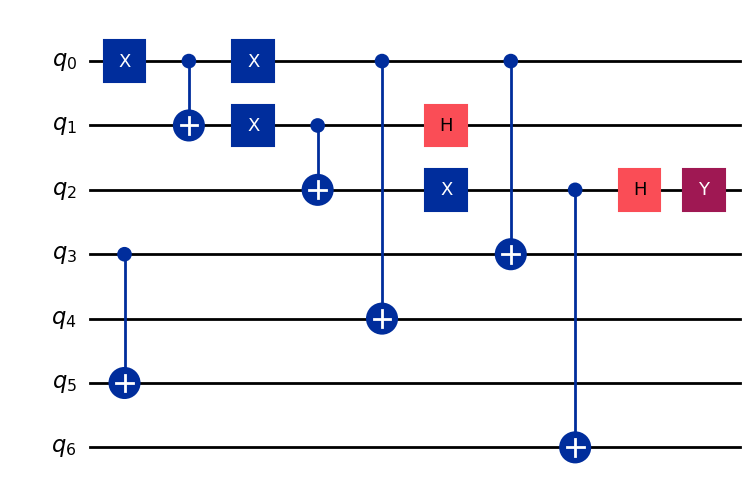

In [38]:
# Plot complete circuit
circuit.get_circuit().draw('mpl')

In [39]:
# Save the backend
if save_backend:
    with open('backends/backend.pkl', 'wb') as file:
        pickle.dump(q_map.backend, file)